# Tutorial #6: Monte Carlo Predictive Coding

In this notebook we will see how to create and train a simple MCPC model to learn a Gaussian data distribution.

In [1]:
from typing import Callable

# These are the default import names used in tutorials and documentation.
import jax
import jax.tree_util as jtu
import jax.numpy as jnp
import equinox as eqx
from optax._src import base 
from optax._src import combine
from optax._src import transform
from typing import Any, Callable, Optional, Union

import pcax as px
import pcax.predictive_coding as pxc
import pcax.nn as pxnn
import pcax.functional as pxf
import pcax.utils as pxu

# px.RKG is the default key generator used in pcax, which is used as default
# source of randomness within pcax. Here we set its seed to 0 for more reproducibility.
# By default it is initialised with the system time.
px.RKG.seed(0)

2024-05-23 19:14:03.487314: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
# We create our model, which inherits from pxc.EnergyModule, so to have access to the notion
# energy. The constructor takes in input all the hyperparameters of the model. Being static
# values, if we intend to save them withing the model we must wrap them into a 'StaticParam'.
class Model(pxc.EnergyModule):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        nm_layers: int,
        act_fn: Callable[[jax.Array], jax.Array]
    ) -> None:
        super().__init__()

        self.act_fn = px.static(act_fn)
        
        self.layers = [pxnn.Linear(input_dim, hidden_dim)] + [
            pxnn.Linear(hidden_dim, hidden_dim, bias=False) for _ in range(nm_layers - 2)
        ] + [pxnn.Linear(hidden_dim, output_dim, bias=False)]

        # the default ruleset for a Vode is: `{"STATUS.INIT": ("h, u <- u",),}` which means:
        # "if the status is set to 'STATUS.INIT', everytime I set 'u', save that value not only
        # in 'u', but also in 'x', which is exactly the behvaiour of a forward pass.
        # By default if not specified, the behaviour is '* <- *', i.e., save everything passed
        # to the vode via __call__ (remember vode(a) equals to vode.set("u", a)).
        #
        # Since we are doing classification, we replace the last energy with the equivalent of
        # cross entropy loss for predictive coding.
        self.vodes = [
            pxc.Vode((hidden_dim,)) for _ in range(nm_layers)
        ]
        
        # 'frozen' is not a magic word, we define it here and use it later to distinguish between
        # vodes we want to differentiate or not.
        # NOTE: any attribute of a Param (except its value) is treated automatically as static,
        # no need to specify it (but it's possible if you like more consistency,
        # i.e., ...frozen = px.static(True)).
        self.vodes[-1].h.frozen = True

    def __call__(self, x, y):
        for v, l in zip(self.vodes[:-1], self.layers[:-1]):
            # remember 'x = v(a)' corresponds to v.set("u", a); x = v.get("x")
            #
            # note that 'self.act_fn' is a StaticParam, so to access it we would have to do
            # self.act_fn.get()(...), however, all standard methods such as __call__ and
            # __getitem__ are overloaded such that 'self.act_fn.__***__' becomes
            # 'self.act_fn.get().__***__'
            x = v(self.act_fn(l(x)))

        x = self.vodes[-1](self.layers[-1](x))

        if y is not None:
            # if the target label is provided (e.g., during training), we save it to the last
            # vode. Given that the 'froze' it, its value will not be upadated during inference,
            # so we need to fix it only once for each new sample, usually during the init step.
            self.vodes[-1].set("h", y)

        # at least with this architecture, the input activation of the last vode is the actual
        # output of the model ('h' is fixed to the label during training or 'h = u' during eval)
        return self.vodes[-1].get("u")

In [3]:
# vmap is used to specify the batch dimension of the input data. Remember jax doesn't handle it
# implicitly but relies on the user to explicitly tell it over which dimension to parallelise the
# computation. That is, we always define a computational graph on a single sample, and then batch
# the computation over the given mini-batch. We use the jax syntax for in_axes, out_axes, axis_name,
# and the introduce a new parameter, kwargs_mask, to specify the batch information over the kwargs
# (which, just as a reminder, have the property of being automatically tracked by pcax).
# pxu.utils.mask has an in-depth explanation about how masking work. Here, we simply use the Mask
# object, which, in this case, replaces every parameter that matches any of the given types with '0',
# meaning that their value is batched over the 0th dimension (which is the case for the vode values
# and caches), and with 'None' the non matching ones (such as the weights, which are shared across
# different samples).
# Both positional input arguments and output are batched over the 0th dimension, so we specify it.
@pxf.vmap(pxu.Mask(pxc.VodeParam | pxc.VodeParam.Cache, (None, 0)), in_axes=(0, 0), out_axes=0)
def forward(x, y, *, model: Model):
    return model(x, y)

# Similarly here, we specify 'out_axes=(None, 0)' since the function returns two values, the first
# a single float storing the total energy of the model (not batched, but summed over the batch
# dimension; this is a requirement of the gradient transformation, which jax requires taking a
# scalar function in input and so a single scalar output). To follow on this, 'axis_name' is specified
# so that we can return the sum over the batch dimension as required (this is standard jax syntax).
@pxf.vmap(pxu.Mask(pxc.VodeParam | pxc.VodeParam.Cache, (None, 0)), in_axes=(0,), out_axes=(None, 0), axis_name="batch")
def energy(x, *, model: Model):
    y_ = model(x, None)
    return jax.lax.psum(model.energy().sum(), "batch"), y_

In [4]:
# JIT is Just In Time compilation, which effectively compiles our code for fast CPU/GPU executioning
# removing all python overhead.
# 'T' is an hyperparameter that determines the number of inferences steps (and therefore the computational flow).
# A such, it must be a static value. We can either specify it using 'static_argnums' (which however is only available
# when using 'jit'), or pass it as a static parameter, in which case we would to 'train_on_batch(px.static(T), ...)'.
#
# Remember that pcax distinguishes between positional and keyword arguments, tracking only the parameters in latter ones.
# Since we don't care about tracking of 'x' and 'y', we pass them as simple jax.Arrays as positional arguments. On the
# other hand, both the model and the optimizers, may have parameters that are going to change and we want to track, so
# we pass them as keyword arguments.
@pxf.jit(static_argnums=0)
def train_on_batch(
    T: int,
    x: jax.Array,
    y: jax.Array,
    *,
    model: Model,
    optim_w: pxu.Optim,
    optim_h: pxu.Optim
):
    def h_step(i, x, *, model, optim_h):
        with pxu.step(model, clear_params=pxc.VodeParam.Cache):
            (e, y_), g = pxf.value_and_grad(
                pxu.Mask(pxu.m(pxc.VodeParam).has_not(frozen=True), [False, True]),
                has_aux=True
            )(energy)(x, model=model)
        optim_h.step(model, g["model"])
        return x, None

    print("Training!")  # this will come in handy later
    # This only sets an internal flag to be "train" (instead of "eval")
    model.train()
    # optim_h.init(pxu.Mask(pxu.m(pxc.VodeParam).has_not(frozen=True))(model))
    
    # Init step
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        forward(x, y, model=model)
    
    # Inference steps
    pxf.scan(h_step, xs=jax.numpy.arange(T))(x, model=model, optim_h=optim_h)

    # Learning step
    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        (e, y_), g = pxf.value_and_grad(pxu.Mask(pxnn.LayerParam, [False, True]), has_aux=True)(energy)(x, model=model)
    optim_w.step(model, g["model"])

    # add weight normalisation  / not needed here
    # px.tree_apply(
    #     lambda layer: layer.weight.set(layer.weight.get() / jnp.linalg.norm(layer.weight.get(), axis=0)),
    #     lambda x: hasattr(x, "weight"),
    #     model,
    #     recursive=False
    # )

    # optim_h.clear()

from tqdm import tqdm
# Standard training loop
def train(dl, T, *, model: Model, optim_w: pxu.Optim, optim_h: pxu.Optim):
    model.vodes[-1].h.frozen = True
    for x, y in tqdm(dl):
        train_on_batch(T, x, y, model=model, optim_w=optim_w, optim_h=optim_h)

In [5]:
import numpy as np
from scipy.stats import wasserstein_distance

@pxf.jit(static_argnums=0)
def eval_on_batch(
    T: int,
    x: jax.Array, 
    *, 
    model: Model,
    optim_h: pxu.Optim
    ):
    def h_step(i, x, *, model, optim_h):
        with pxu.step(model, clear_params=pxc.VodeParam.Cache):
            (e, y_), g = pxf.value_and_grad(
                pxu.Mask(pxu.m(pxc.VodeParam).has_not(frozen=True), [False, True]),
                has_aux=True
            )(energy)(x, model=model)
        optim_h.step(model, g["model"])
        return x, None

    print("Evaluation!")  
    model.train()
    # optim_h.init(pxu.Mask(pxu.m(pxc.VodeParam).has_not(frozen=True))(model))

    if model.vodes[-1].h.frozen:
        print("vode[-1] should not be frozen! set frozen=False before calling eval function.")

    # Init step
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        forward(x, None, model=model)
    
    # Inference steps
    x, y_ = pxf.scan(h_step, xs=jax.numpy.arange(T))(x, model=model, optim_h=optim_h)
    # optim_h.clear()

# MCPC evaluation loop for 1D data
def eval(dl, T, *, model: Model, optim_h: pxu.Optim):
    model.vodes[-1].h.frozen = False
    ys = []
    ys_ = []
    
    for x, y in dl:
        eval_on_batch(T, x, model=model, optim_h=optim_h)
        ys.append(y)
        ys_.append(model.vodes[-1].get("h"))

    ys = np.concatenate(ys, axis=0)
    ys_ = np.concatenate(ys_, axis=0)

    return wasserstein_distance(ys.squeeze(), ys_.squeeze()), ys_

In [6]:
import optax

batch_size = 32

model = Model(
    input_dim=1,
    hidden_dim=1,
    output_dim=1,
    nm_layers=2,
    act_fn= lambda x:x
)

In [7]:
## define noisy sgd optimiser for MCPC
def sgdld(
    learning_rate: base.ScalarOrSchedule,
    momentum: Optional[float] = None,
    h_var: float = 1.0,
    gamma: float = 0.,
    nesterov: bool = False,
    accumulator_dtype: Optional[Any] = None,
    seed: int = 0
) -> base.GradientTransformation:
  eta = 2*h_var*(1-momentum)/learning_rate if momentum is not None else 2*h_var/learning_rate
  return combine.chain(
      transform.add_noise(eta, gamma, seed),
      (transform.trace(decay=momentum, nesterov=nesterov,
                       accumulator_dtype=accumulator_dtype)
       if momentum is not None else base.identity()),
      transform.scale_by_learning_rate(learning_rate)
  )


In [8]:
h_optimiser_fn = sgdld
lr = 1e-2
momentum = 0.5
h_var = 1.0
gamma = 0.
lr_p = 1e-3

# only thing to note here is how optimizers are created. In particular,
# we first want all the parameters of the model to exist, so that the optimizers
# can capture them for optimization. This requires performing a dummy forward pass.
# Note that the batch_size is an hyperparameter of the model and determines, among
# other things, the shape of the Vode parameters, and thus must be kept as much
# constant as possible (each change would trigger ricompilation of the jitted functions).
with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
    forward(jax.numpy.zeros((batch_size, 1)), None, model=model)
    optim_h = pxu.Optim(h_optimiser_fn(lr, momentum, h_var, gamma), pxu.Mask(pxu.m(pxc.VodeParam).has_not(frozen=True))(model))
    optim_w = pxu.Optim(optax.adam(lr_p), pxu.Mask(pxnn.LayerParam)(model))
    # make optimiser that also optimises the activity of the model layer[-1]
    model.vodes[-1].h.frozen = False
    forward(jax.numpy.zeros((batch_size, 1)), None, model=model)
    optim_h_eval = pxu.Optim(h_optimiser_fn(lr, momentum, h_var, gamma), pxu.Mask(pxu.m(pxc.VodeParam))(model))
    model.vodes[-1].h.frozen = True

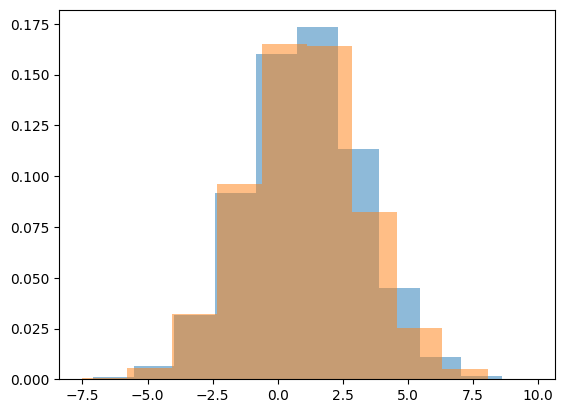

In [9]:
import matplotlib.pyplot as plt
import numpy as np
# generate Gaussian data

mean = 1
var = 5

nm_elements = 10240
X = np.zeros((batch_size * (nm_elements // batch_size), 1))
y = np.random.randn(batch_size * (nm_elements // batch_size)).reshape(-1,1) * np.sqrt(var) + mean

nm_elements_test = 1024
X_test = np.zeros((batch_size * (nm_elements_test // batch_size), 1))
y_test = np.random.randn(batch_size * (nm_elements // batch_size)).reshape(-1,1) * np.sqrt(var) + mean

plt.hist(y, alpha = 0.5, density=True)
plt.hist(y_test, alpha = 0.5, density=True);

In [10]:
# we split the dataset in training batches and do the same for the generated test set.
train_dl = list(zip(X.reshape(-1, batch_size, 1), y.reshape(-1, batch_size, 1)))
test_dl = tuple(zip(X_test.reshape(-1, batch_size, 1), y_test.reshape(-1, batch_size, 1)))

In [11]:
import random

nm_epochs = 5120 // (nm_elements // batch_size)

# Note how the text "Training!" appears only once. This is because 'train_on_batch' is executed only once,
# and then its compiled equivalent is instead used (which only cares about what happens to jax.Arrays and
# discards all python code).
T = 250
T_eval = 10000
w, y_ = eval(test_dl, T = T_eval, model=model, optim_h=optim_h_eval)
print(f"Epoch {0}/{nm_epochs} - Wasserstein distance: {w :.2f}")
for e in range(nm_epochs):
    random.shuffle(train_dl)
    train(train_dl, T=T, model=model, optim_w=optim_w, optim_h=optim_h)
    if e %5 == 4 or e == nm_epochs - 1:
        w, y_ = eval(test_dl, T = T_eval, model=model, optim_h=optim_h_eval)
        print(f"Epoch {e + 1}/{nm_epochs} - Wasserstein distance: {w :.2f}")

print(f"Learned data distribution has mean {y_.mean():.2f} and var {y_.var():.2f} ")
print(f"Learned parameters weight {model.layers[-1].nn.weight.get()[0,0] :.2f} and bias {model.layers[0].nn.bias.get()[0] :.2f}")

Evaluation!
Epoch 0/16 - Wasserstein distance: 1.50


  0%|                                                                                          | 0/320 [00:00<?, ?it/s]

Training!


100%|███████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 372.08it/s]


Epoch 5/16 - Wasserstein distance: 0.39


100%|███████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 368.45it/s]


Epoch 10/16 - Wasserstein distance: 0.14


100%|███████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 374.14it/s]


Epoch 15/16 - Wasserstein distance: 0.17


100%|███████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 368.15it/s]


Epoch 16/16 - Wasserstein distance: 0.14
Learned data distribution has mean 0.93 and var 4.59 
Learned parameters weight -1.92 and bias -0.50


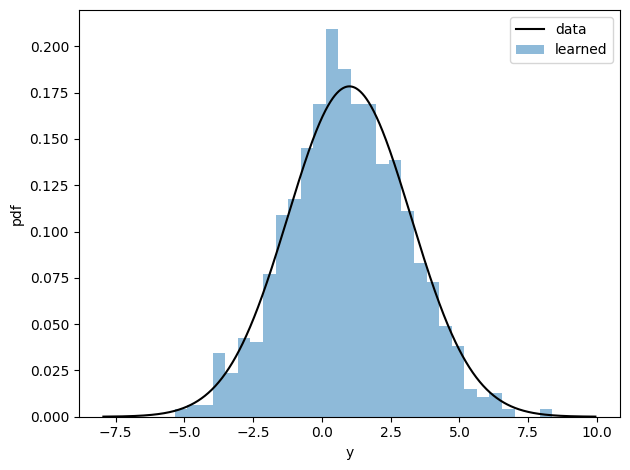

In [14]:
import scipy.stats as stats
x = np.linspace(mean-4*np.sqrt(var), mean+4*np.sqrt(var), 1000)
y = stats.norm.pdf(x, mean, np.sqrt(var))


plt.plot(x,y, "k", label="data")
# plt.hist(y, label = "data", density=True, alpha=0.5, bins=30)
plt.hist(y_, label = "learned", density=True, alpha=0.5, bins=30)
plt.ylabel("pdf")
plt.xlabel("y")
plt.legend()
plt.tight_layout()
plt.show()